In [36]:
import numpy as np
from numpy.random import default_rng
import skimage as ski
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display

In [58]:
class total_variation():
    """
    total variation of 2D image u with shape (n1, n2). Scaled by a constant
    regularization parameter scale. Corresponds to the functional 
        scale * TV(u)
    with u in R^{n1 x n2}
    
    __init__ input:
        - n1, n2:   shape of u
        - scale:    scaling factor, usually a regularization parameter
        
    __call__ input:
        - u:        image of shape n1,n2 or n1*n2,
                    
    TV is computed on a grid via finite differences, assuming equidistant 
    spacing of the grid. The gradient of this potential does not exist since 
    TV is not smooth.
    The proximal mapping is approximated using the dual problem. Pass either 
    a maximum number of steps, an accuracy (in the primal-dual gap), or both 
    to the prox evaluation, for more details see 
        total_variation.inexact_prox
    """
    def __init__(self, n1, n2, scale=1):
        self.n1 = n1
        self.n2 = n2
        self.scale = scale
        
    def _imgrad(self, u):
        """
        applies a 2D image gradient to the image u of shape (n1,n2)
        
        Parameters
        ----------
        u : numpy 2D array, shape n1, n2
            Image

        Returns
        -------
        (px,py) image gradients in x- and y-directions.

        """
        px = np.concatenate((u[1:,:]-u[0:-1,:], np.zeros((1,self.n2))),axis=0)
        py = np.concatenate((u[:,1:]-u[:,0:-1], np.zeros((self.n1,1))),axis=1)
        return np.concatenate((px[np.newaxis,:,:],py[np.newaxis,:,:]), axis=0)
    
    def _imdiv(self, p):
        """
        Computes the negative divergence of the 2D vector field px,py.
        can also be seen as a tensor from R^(n1xn2x2) to R^(n1xn2)

        Parameters
        ----------
            - p : 2 x n1 x n2 np.array

        Returns
        -------
            - divergence, n1 x n2 np.array
        """
        u1 = np.concatenate((-p[0,0:1,:], -(p[0,1:-1,:]-p[0,0:-2,:]), p[0,-2:-1,:]), axis = 0)
        u2 = np.concatenate((-p[1,:,0:1], -(p[1,:,1:-1]-p[1,:,0:-2]), p[1,:,-2:-1]), axis = 1)
        return u1+u2
    
    def __call__(self, u):
        """
        Computes the TV-seminorm of u
        
        Parameters 
        ----------
        u : numpy array of shape n1, n2
        
        Returns
        -------
        TV(u) (scalar)
        """
        return self.scale * np.sum(np.sqrt(np.sum(self._imgrad(u)**2,axis=0)))
    
    def inexact_prox(self, u, gamma=1, epsilon=None, max_iter=np.Inf, verbose=False):
        """
        Computing the prox of TV is solving the ROF model with FISTA
            
        parameters:
            - u:        image to be denoised, shape self.n1, self.n2
            - gamma:    prox step size
            - epsilon:  accuracy for duality gap stopping criterion
            - maxiter:  maximum number of iterations
            - verbose:  verbosity
        """
        if epsilon is None and max_iter is np.Inf:
            raise ValueError('provide either an accuracy or a maximum number of iterations to the tv prox please')
        checkAccuracy = True if epsilon is not None else False
        # iterative scheme to minimize the dual objective
        p = np.zeros((2,self.n1,self.n2))
        q = np.copy(p)
        
        stopcrit = False
        t, t_prev = 1, 1
        
        i = 0
        if verbose: sys.stdout.write('run FISTA on dual ROF model: {:3d}% '.format(0)); sys.stdout.flush()
        
        while i < max_iter and not stopcrit:
            i = i + 1
            p_prev = np.copy(p)
            
            v = q - 1/(8*gamma) * self._imgrad(gamma*self._imdiv(q) - u)
            p = v/np.maximum(1, np.sqrt(np.sum(v**2,axis=0))/self.scale)[np.newaxis,:,:]
            
            t_new = (1+np.sqrt(1+4*t**2))/2
            t, t_prev = t_new, t
            q = p + (t_prev-1)/t * (p - p_prev)
            
            # stopping criterion: check if primal-dual gap < epsilon
            if checkAccuracy:
                div_p = self._imdiv(p)
                h = gamma/2 * np.sum(div_p**2)
                primal = self(u-gamma*div_p) + h
                conj_TV_p = np.max(np.sqrt(np.sum(p**2,axis=0)))
                dual_inadmissible = conj_TV_p > self.scale+1e-12
                dual = np.Inf if dual_inadmissible else h - np.sum(div_p * u) # dual value. dual iterate should never be inadmissible since we project in the end
                dgap = primal+dual
                stopcrit = dgap <= epsilon
                if dgap < -5e-15: # for debugging purpose
                    raise ValueError('Duality gap was negative (which should never happen), please check the prox computation routine!')
                if verbose: sys.stdout.write('\b'*5 + '{:3d}% '.format(int(i/max_iter*100))); sys.stdout.flush()
        if verbose: sys.stdout.write('\b'*5 + '100% '); sys.stdout.flush()
        return (u - gamma*self._imdiv(p)), i
    
class pdhg():
    """solve the problem
        f(Kx) + g(x) + h(x)
    using PDHG algorithm
        x_{k+1} = prox_{tau*g}(x_k - tau*(dh(x_k) + Kt*y_k))
        x_r = 2*x_{k+1} - x_k
        y_{k+1} = prox_{sigma*fconj}(y_k + sigma*K*x_r)
    with differentiable h and possibly non-smooth f and g
    """
    def __init__(self, x0, y0, tau, sigma, n_iter, prox_fconj, k, kt, prox_g, dh):
        self.iter = 0
        self.n_iter = n_iter
        self.x_shape = x0.shape
        self.y_shape = y0.shape
        self.x = np.copy(x0)
        self.y = np.copy(y0)
        
        self.tau = tau
        self.sigma = sigma
        self.prox_fconj = prox_fconj
        self.k = k
        self.kt = kt
        self.prox_g = prox_g
        self.dh = dh
    
    def compute(self, verbose=False):
        while self.iter < self.n_iter:
            self.iter += 1
            x_prev = self.x
            self.x = self.prox_g(self.x - self.tau*(self.dh(self.x)+self.kt(self.y)), self.tau)
            self.y = self.prox_fconj(self.y + self.sigma*self.k(2*self.x - x_prev), self.sigma)
        return self.x
    
def power_method(ata, n, tol, max_iter, verbose=False):
    """power method to compute the maximum eigenvalue of the linear op at*a"""
    x = np.random.normal(size=(n,n))
    x = x/np.linalg.norm(x.ravel())
    val, val_old = 1, 1
    for k in range(max_iter):
        x = ata(x)
        val = np.linalg.norm(x.ravel())
        rel_var = np.abs(val-val_old)/val_old
        val_old = val
        x = x/val
        if rel_var < tol:
            break
    return val

def tv_rec(y,mu_tv,noise_std,s,A,Aadj,max_ev_AtA):
    """
    Solves the CT reconstruction problem with TV regularization assuming Gaussian noise using PDHG
        argmin 1/2*sigma2 ||Ax-y||^2 + mu_tv * TV(x)

    Input:
        - y: noisy sinogram
        - mu_tv: TV regularization parameter
        - sigma2: Gaussian noise variance in sinogram
        - s: shape of output image
        - A, Aadj, max_ev_ata: forward and adjoint operator and largest eigenvalue of AtA
    """
    prox_fconj = lambda p, tau: p/np.maximum(1,1/mu_tv*(np.sqrt(np.sum(p**2,axis=0))[np.newaxis,...]))
    prox_g = lambda x, tau : x
    dh = lambda x : 1/noise_std**2 * Aadj(A(x) - y)

    x0_pd, y0_pd = np.zeros(s), np.zeros((2,)+s)
    L = max_ev_AtA/noise_std**2
    tau, sigma = 1/(np.sqrt(8)+L), 1/np.sqrt(8)
    n_iter = 200
    tv = total_variation(s[0],s[1])
    k,kt = tv._imgrad, tv._imdiv
    opt = pdhg(x0_pd, y0_pd, tau, sigma, n_iter, prox_fconj, k, kt, prox_g, dh)
    opt.compute()
    return opt.x



# Quantifying Uncertainty in a Reconstruction

Assume we have a great, accurate inversion algorithm and with that, we have computed some solution $x^{\ast}$ from the data observation $y$ in the inverse problem 
$$y = A(x) + n$$
> How certain are we that $x^{\ast}$ is a representative solution? 
> How large are the errors that we could have made because of the stochastic nature of the noise? 

For instance, consider the following example of making two independent CT scans of the same object:

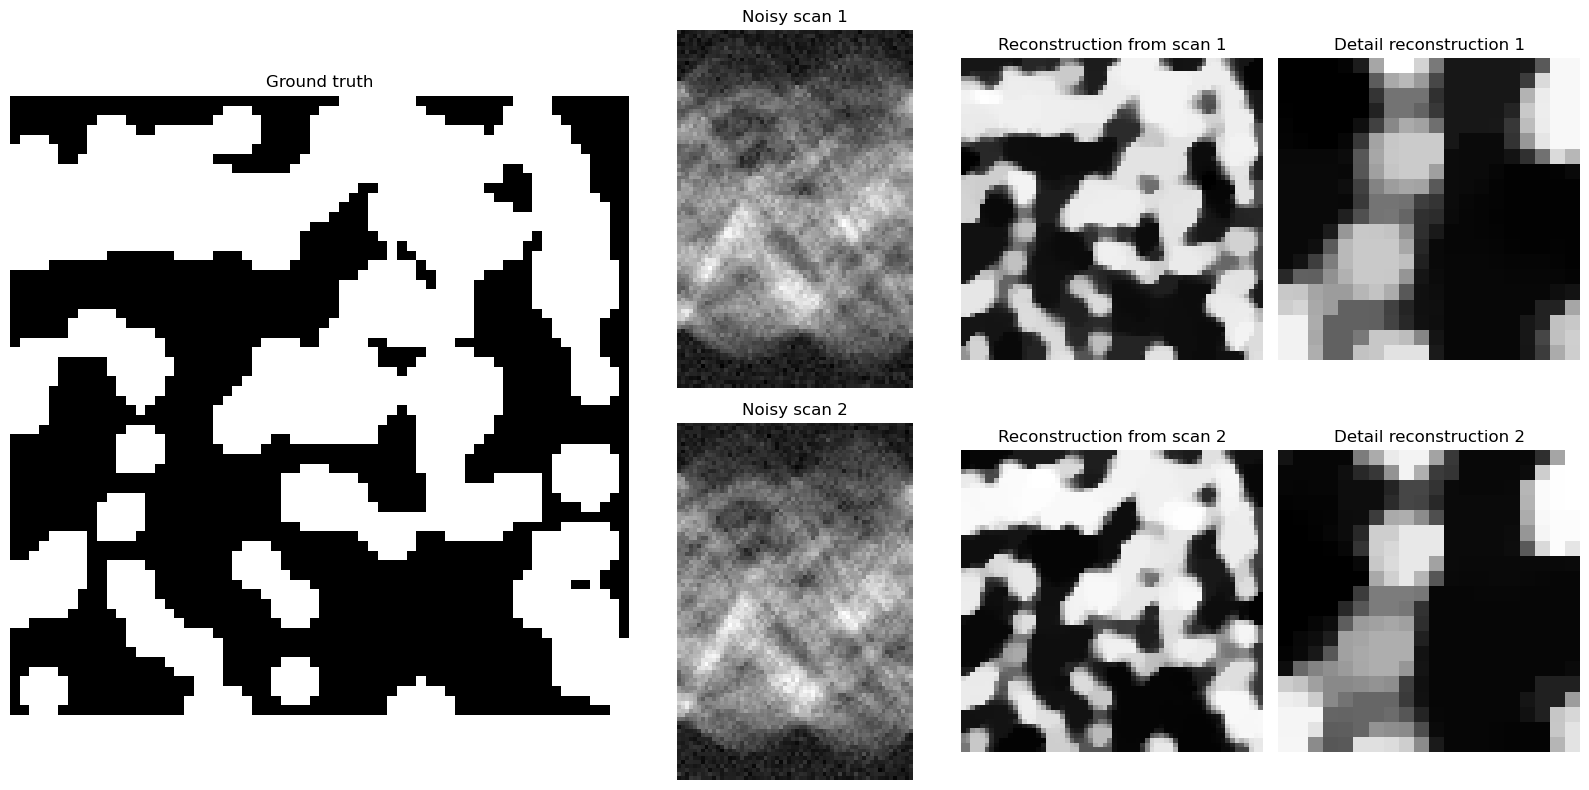

In [61]:
import matplotlib.gridspec as gridspec

rng = default_rng(2452)

fig = plt.figure(tight_layout=True,figsize=(16,8))
gs = gridspec.GridSpec(2, 5)

phantom = ski.data.binary_blobs(length=64,seed=11111)   # with some newer scikit-image versions, seed= has to be replaced by rng=
theta = np.linspace(0,180, endpoint = False, num=60)
sinogram =  ski.transform.radon(phantom, theta, circle=False)

# forward and backprojection operator
A = lambda x : ski.transform.radon(x,theta,circle=False)
Aadj = lambda sino : ski.transform.iradon(sino,theta,circle=False,filter_name=None)
AtA = lambda x : Aadj(A(x))
max_ev_AtA = power_method(AtA, phantom.shape[0], 1e-4, int(3e2))

# add two different noise realizations to the sinogram to simulate two independent scans
sigma = 3
noise1 = sigma*rng.normal(size=sinogram.shape)
noise2 = sigma*rng.normal(size=sinogram.shape)
y1 = sinogram + noise1
y2 = sinogram + noise2
mu_tv = 0.1
rec1 = tv_rec(y1,mu_tv,sigma,phantom.shape,A,Aadj,max_ev_AtA)
rec2 = tv_rec(y2,mu_tv,sigma,phantom.shape,A,Aadj,max_ev_AtA)

# plot results
ax = [fig.add_subplot(gs[:, 0:2])]
for i in range(6): ax.append(fig.add_subplot(gs[i%2,2+i//2]))
ax[0].imshow(phantom, cmap='gray'), ax[0].set_title('Ground truth')
ax[1].imshow(y1, cmap='gray'), ax[1].set_title('Noisy scan 1')
ax[2].imshow(y2, cmap='gray'), ax[2].set_title('Noisy scan 2')

# apply TV reconstruction here instead to visualize different smoothing
ax[3].imshow(rec1, cmap='gray'), ax[3].set_title('Reconstruction from scan 1')
ax[4].imshow(rec2, cmap='gray'), ax[4].set_title('Reconstruction from scan 2')
ax[5].imshow(rec1[30:50,5:25], cmap='gray'), ax[5].set_title('Detail reconstruction 1')
ax[6].imshow(rec2[30:50,5:25], cmap='gray'), ax[6].set_title('Detail reconstruction 2')

for axes in ax: axes.axis('off')

In order to answer, we have to give some probabilistic meaning to the distribution of possible solutions $x$, noise $n$ and the observed data $y$. We assume that both $x$ and $n$ are instantiations of random variables with certain probability distributions. For the marginal distribution of possible solutions, we write $x \sim \pi_0$. The probability of observing $y = A(x)+n$ given some $x$ is denoted $\pi_{y|x}$.

$\pi_0$ is called the **prior distribution**, it encodes prior information, assumptions or belief about the possible nature of our reconstruction $x$. Assume that $\pi_0$ has a probability density function (pdf) $p_0(x)$.

The density $p(\cdot|x)$ of the distribution $\pi_{y|x}$ is called the **likelihood**.

Once we make an observation $y$, by **Bayes' law** the **posterior distribution** of $x$ after seeing $y$ has the density
$$ p(x|y) = \frac{p(y|x)p_0(x)}{p(y)} \propto p(y|x) p_0(x). $$

**Examples for priors**
- If we believe our solution $x$ should be close to some a priori known value $\hat x$, then our prior might look something like $p_0(x) = \exp(-\frac{1}{2\sigma^2}||x-\hat x||_2^2)/Z$. The normalization constant $Z$ ensures that $p_0$ is a valid pdf, we omit it from now on and write "$\propto$" for proportionality. According to this prior density, values closer to $\hat x$ are assigned larger probability values, since they are assumed to be more likely.
- If we believe that $x$ is likely to have little edges/contrast jumps, we might pick a prior like $p_0(x) \propto \exp(-\mathrm {TV}(x))$.
- In general, distributions of the form $ p_0(x) \propto \exp(-G(x))$ for any $G$ are called **Gibbs priors**.

**Examples for likelihood functions**
- Homoschedastic Gaussian observation noise $n \sim \mathrm{N}(0,I)$ corresponds to a likelihood of the form $ p(y|x) \propto \exp(- ||y-A(x)||_2^2 ) $.
- If the observed variable $y$ follows a Poisson distribution $y \sim \mathrm{Pois}(A(x))$, then $p(y|x) \propto \frac 1{y!} \exp(-A(x)) A(x)^y $ for all $y \in \mathbb{N}$.